# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [0]:
# Change here using YOUR first and last names
fn1 = "manon"
ln1 = "rivoire"
fn2 = "alexis"
ln2 = "gerbeaux"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_rivoire_manon_and_gerbeaux_alexis.ipynb


In [0]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [0]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [0]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [0]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2 ## vecteur des normes au carré des vecteurs colonnes Ai. nx1 dimensional vector containing a Lipschitz constant specific to each of the n features (that is specific to each of the n coordinates)
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features # the index of the coordinate to update corresponds to the rest in the Euclidean Division of the number of iterations by the number of features
        # TODO
        old_w_j = w[j].copy()
        step = 1/lips_const[j]
        grad = (A[:,j].T).dot(residuals)
        w[j] += step*grad
        # update residuals: 
        # We only update the jth coordinate of the vector of residuals since only the jth coordinate of the vector of weights has been modified
        residuals += np.dot(A[:,j], old_w_j - w[j]) ##écrire r_t+1 - r_t et écrire en fct de w_t+1 - w_t
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)

def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j].copy()
        w[j] -= (1/lips_const[j])*gradient[j] ##We only update the jth coordinate of the vector of weights
        # update gradient:
        gradient += gram[:,j]*(w[j] - old_w_j) ##We only update the jth coordinate of the gradient vector since we only have updated the jth coordinate of the vector of weights
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

In [0]:
%%time
w_min_cyclic_cd, obj_w_cyclic_cd = cyclic_cd(A, b, 10000)

CPU times: user 220 ms, sys: 5.94 ms, total: 226 ms
Wall time: 428 ms


In [0]:
%%time 
w_min_greedy_cd, obj_w_greedy_cd = greedy_cd(A, b, 10000)

CPU times: user 265 ms, sys: 24 ms, total: 289 ms
Wall time: 160 ms


**Questions :**
- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- from a practical point of view, could you use greedy CD for ridge logistic regression? to solve OLS, but with 100,000 features? Explain your answers.

### Compute a precise minimum with your favorite solver

Minimum computed with l-bfgs solver

In [0]:
from scipy.optimize import fmin_l_bfgs_b

def grad(w, A, b):
    return A.T.dot(A.dot(w) - b)
    
def loss(w, A, b):
    return norm(A.dot(w) - b) ** 2 / 2
    
w_init = np.zeros(n_features)

w_min, f_min, _ = fmin_l_bfgs_b(loss, w_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)


print(f_min)
print(w_min) #best solution to the opti pb so we will compare the other minimizers to this one assuming it's the 'real' solution
print(norm(grad(w_min, A, b)))

466.38497653376567
[-0.00772678  1.1722585  -0.26704868  0.70004526  0.6395015   0.76854499
 -0.6715586  -1.16392572  0.04667156 -0.19553794  1.90429109  1.40048949
  0.49102095 -0.84138107 -1.44433611  1.60925495 -1.04829763 -0.46741439
 -1.56420944 -0.5049202   0.24166775 -0.17082697 -1.8685883  -1.45447257
  0.33296101  0.95929147  0.55429929  1.14589981 -0.06046799 -0.4264222
  2.02338434 -1.57558751 -0.23636267 -1.33706995  1.19093151 -0.39092006
  0.86724978  0.26923088 -0.85206818 -0.07024918 -0.3642956  -0.00576861
 -1.56783243 -1.92839434 -1.53959864 -0.38137738 -0.58731018 -1.72603575
  0.39133318 -0.28659137  0.2162589  -0.22917056  0.93575223 -0.49609361
 -0.32023458  1.05655835  1.01878796  0.98860962 -0.81709049 -0.95800001
 -1.32897382  0.06565243  0.46755933 -1.15942364  0.3859497  -0.3170157
  0.47849    -0.32858091 -0.66056608 -1.01725307  0.53129895  2.02183154
  0.47129171 -0.90273392  1.39594999  0.03366695  0.35948564  0.3089695
 -0.30875605  1.39495298 -0.0519806

Other minimim computed

In [0]:
w_min_ols,_,_,_, = np.linalg.lstsq(A, b)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


### Compare the performance of cyclic and greedy CD

First, let compare the difference between the minimum computed with the solvers above and the minimum obtained with cyclic coordinate descent and greedy coordinate descent.

Pour la descente par coordonnée cyclique :

In [0]:
print("Distance au minimiseur(ols) : %e" %np.linalg.norm(w_min_ols - w_min_cyclic_cd))

Distance au minimiseur(ols) : 3.359763e-14


In [0]:
print("Distance au minimiseur(l-bfgs) : %e" %np.linalg.norm(w_min - w_min_cyclic_cd))

Distance au minimiseur(l-bfgs) : 1.535013e-08


In [0]:
print("Distance au minimum(l-bfgs) : %e" %np.linalg.norm(f_min - obj_w_cyclic_cd[-1]))

Distance au minimum(l-bfgs) : 5.115908e-13


Pour la descente par coordonnée greedy :

In [0]:
print("Distance au minimiseur(ols) : %e" %np.linalg.norm(w_min_ols - w_min_greedy_cd))

Distance au minimiseur(ols) : 3.519856e-14


In [0]:
print("Distance au minimiseur(l-bfgs) : %e" %np.linalg.norm(w_min - w_min_greedy_cd))

Distance au minimiseur(l-bfgs) : 1.535012e-08


In [0]:
print("Distance au minimum(l-bfgs) : %e" %np.linalg.norm(f_min - obj_w_greedy_cd[-1]))

Distance au minimum(l-bfgs) : 2.273737e-13


Comparons maintenant les vitesses de convergence des deux méthodes de descente par coordonée

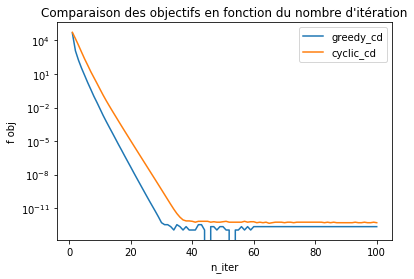

In [0]:
#import seaborn as sns
y = obj_w_greedy_cd - f_min
z = obj_w_cyclic_cd - f_min

x = np.arange(1, len(y)+1)

plt.plot(x, y, label='greedy_cd')
plt.plot(x, z, label='cyclic_cd')
plt.yscale('log')
plt.title("Comparaison des objectifs en fonction du nombre d'itération")
plt.xlabel('n_iter')
plt.ylabel('f obj')
plt.legend(loc='best')
plt.show()

Les deux méthodes de descente par coordonnées sont linéaires en échelle logarithmique. D'après la proposition de Beck and Tetruashvilli (pour cycllic_cd) la convergence est en 1 sur le nombre d'itérations. En échelle logarithmique (en base 10) il est donc normal de retrouver des convergences linéaires.<br>
La descente par coordonnées greedy est un peu plus rapide que la cyclique en termes d'itérations. Ceci s'explique car l'algo greedy sélectionne les coordonnées pour lesquelles le gradient est le plus grand en premier. Cependant, pour la méthode greedy le temps d'une itération est plus grand car il doit calculer l'argmax du gradient. On remarque déjà une différence de temps pour 5000 ou 50000 itérations.

### From a practical point of view, could you use greedy CD for
- ridge logistic regression?
- to solve OLS, but with 100,000 features?

A cause de la recherche du maximum du gradient sur les features, cette opération peut devenir vite très coûteuse comparé à l'algorithme cyclique qui ne cherche pas à calculer cela et itère sur chaque feature à tour de rôle. En effet avec 100,000 features, il est en pratique impossible de se servir de l'algo de descente par coordonnéees greedy.<br>
La constante de Lipschitz est un peu différente avec la pénalisation ridge. 

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Assuming uniqueness of the solution, show that:
$$ \lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

<font color='blue'>

**Proof**

We know : 
\begin{equation}
  \hat{w} \in arg min \sum_{i = 1}^{n} \log(1 + e^{-y_{i}w^{T}x_{i}}) + \lambda \left \| w \right \|_{1} \Leftrightarrow 0 \in \partial [\sum_{i = 1}^{n} \log(1 + e^{-y_{i}w^{T}x_{i}}) + \lambda \left \| w \right \|_{1}](\hat{w})
\end{equation}

So : 
\begin{equation}
\hat{w} = 0 \Leftrightarrow 0\in \partial [\sum_{i = 1}^{n} \log(1 + e^{-y_{i}w^{T}x_{i}}) + \lambda \left \| w \right \|_{1}](0)
\end{equation}

\begin{equation}
\Leftrightarrow 0 \in \sum_{i = 1}^{n} \nabla \log(1 + e^{-y_{i}w^{T}x_{i}})(0) + \lambda \partial \left \| w \right \|_{1}(0)
\end{equation}

Yet : 

\begin{equation}
  \nabla \log(1 + e^{-y_{i}w^{T}x_{i}})(0) = -\frac{x_{i}^{T}y_{i}}{1+e^{y_{i}w^{T}x_{i}}}(0) = -\frac{x_{i}^{T}y_{i}}{2}
\end{equation}

\begin{equation} 
\sum_{i = 1}^{n} \nabla \log(1 + e^{-y_{i}w^{T}x_{i}})(0) = -\frac{X^\top y}{2}
\end{equation}

And : 

\begin{equation}
\partial \left \| w \right \|_{1}(0) = [-1,1]^{p}
\end{equation}

Thus : 

\begin{equation}
\hat{w} = 0 \Leftrightarrow 0 \in -\frac{X^\top y}{2} + \lambda [-1,1]^{p}
\end{equation}

\begin{equation}
\Leftrightarrow X^\top y \in 2\lambda [-1,1]^{p}
\end{equation}

Therefore : 

\begin{equation}
  \forall j \in {1, \ldots, p},\ -2\lambda \leq (X^\top y)_{j} \leq 2\lambda
\end{equation}

\begin{equation}
  \Leftrightarrow \forall j \in {1, \ldots, p},\ |(X^\top y)_{j}| \leq 2\lambda
\end{equation}

\begin{equation}
  \Leftrightarrow \ max_{1 \leq j \leq p} |(X^\top y)_{j}| \leq 2\lambda 
\end{equation}

\begin{equation}
  \Leftrightarrow \left \| X^\top y \right \|_{\infty} \leq 2\lambda 
\end{equation}

\begin{equation}
  \Leftrightarrow \lambda \geq \frac{\left \| X^\top y \right \|_{\infty}}{2} := \lambda_{max}
\end{equation}

So we have shown that : 

\begin{equation}
  \hat{w} = 0 \Leftrightarrow \lambda \geq \lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}
\end{equation}

</font>

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

<font color='blue'>
    
**Proof**

\begin{equation}
  f(w) = \sum_{i = 1}^{n} \log(1 + e^{-y_{i}w^{T}x_{i}}) = \sum_{i = 1}^{n} \phi(y_{i}w^{T}x_{i})
\end{equation}

Where $\phi$ is the following function : 
\begin{equation}
  \phi(\alpha) = \log(1 + e^{-\alpha})
\end{equation}
    
We would like to find an upper bound to the second derivative of $\phi$. 
    
$\phi$ is $C^{\infty}$ and we have : 
\begin{equation}
  \phi''(\alpha) = \frac{e^{\alpha}}{(1+e^{\alpha})^2}
\end{equation}

We know that : 
\begin{equation}
  (a + b)^2 - 4ab = a^2 + b^2 - 2ab = (a-b)^2 \geq 0
\end{equation}

Let's take $a = 1$ and $b = e^{\alpha}$, then we obtain : 
\begin{equation}
  (1 + e^{\alpha})^2 - 4e^{\alpha} \geq 0 \\
  (1 + e^{\alpha})^2 \geq 4e^{\alpha} \\
  \frac{e^{\alpha}}{(1 + e^{\alpha})^2} \leq \frac{1}{4}\\
  \phi''(\alpha) \leq \frac{1}{4}
\end{equation}
    
And since we have $\phi'' \geq 0$, then we have proved that : 
\begin{equation}
  |\phi''(\alpha)| \leq \frac{1}{4}
\end{equation}

Let keep in mind that by the Mean Value Inequality, we have : <br/>
\begin{equation}
  \forall a, b \in \mathbb{R}, |\phi'(a) - \phi'(b)| \leq sup_\alpha \left\lbrace|\phi''(\alpha)|\right\rbrace |a - b| \leq \frac14 |a - b|
\end{equation}

Let's compute the gradient of $f$ with regards to $w$. 
\begin{equation}
  \nabla f(w) = \nabla \left( \sum_{i = 1}^{n} \phi(y_{i}w^{T}x_{i}) \right) = \sum_{i = 1}^{n} \nabla \phi(y_{i}w^{T}x_{i}) = \sum_{i = 1}^{n} \phi'(y_{i}w^{T}x_{i})y_{i}x_{i}^{T}
\end{equation}

Since we only updates one coordinate of the parameter's vector at a time, then we are going to rewrite the gradient of $f$ in function of the $j^{th}$ coordinate $w_{j}, \forall j \in \left\lbrack 1, p \right\rbrack$ <br/>
\begin{equation}
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | = | \sum_{i = 1}^{n} \phi'(y_{i}(w + te_{j})^{T}x_{i})y_{i}x_{ij} - \sum_{i = 1}^{n} \phi'(y_{i}w^{T}x_{i})y_{i}x_{ij}| \\
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | = | \sum_{i = 1}^{n} \left\lbrack\phi'(y_{i}(w + te_{j})^{T}x_{i}) - \phi'(y_{i}w^{T}x_{i})\right\rbrack y_{i}x_{ij}| \\
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \sum_{i = 1}^{n} | \phi'(y_{i}(w + te_{j})^{T}x_{i}) - \phi'(y_{i}w^{T}x_{i}) | |y_{i}x_{ij}| 
\end{equation} 

We apply the Mean Value Inequality with $a_{i} = y_{i}(w+te_{j})^{T}x_{i}$, $b_{i} = y_{i}w^{T}x_{i}$. 
\begin{equation}
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \sum_{i = 1}^{n} \frac{1}{4}| y_{i}(w+te_{j})^{T}x_{i} - y_{i}w^{T}x_{i}| |y_{i}x_{ij}| \\
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \sum_{i = 1}^{n} \frac{1}{4}| y_{i}\left\lbrack(w^{T} + te_{j}^{T}) - w^{T}\right\rbrack x_{i} | |y_{i}x_{ij}| \\
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \frac{1}{4} \sum_{i = 1}^{n} | y_{i} te_{j}^{T} x_{i} | |y_{i}x_{ij}| \\
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \frac{1}{4} \sum_{i = 1}^{n} | y_{i} t x_{ij} | |y_{i}x_{ij}| \\
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \frac{1}{4} \sum_{i = 1}^{n} |t||y_{i}x_{ij}|^{2} \\
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \frac{1}{4} \sum_{i = 1}^{n} |t|y_{i}^{2}x_{ij}^{2} 
\end{equation} 

But $\forall i \in \left\lbrack 1, n \right\rbrack, y_{i} \in \left\lbrace -1, +1 \right\rbrace$, therefore we obtain : 
\begin{equation}
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \frac{1}{4} \sum_{i = 1}^{n} |t|x_{ij}^{2} \\
  | \nabla_{j} f(w + te_{j}) - \nabla_{j} f(w) | \leq \frac{|t|}{4} \sum_{i = 1}^{n} x_{ij}^{2} \\
  | \nabla_{j} L(w + te_{j}) - \nabla_{j} L(w) | \leq |t| \frac{\left \| X_{j} \right \|^{2} }{4}
\end{equation} 

Thus for sparse Logistic Regression, the coordinate-wise Lipshitz constant of the smooth term, $\gamma_{j}$, can be taken equal to  $\Vert X_j \Vert^2 / 4$ , where  Xj  denotes the  j -th column of  X.

</font>

You are now ready to code **cyclic proximal coordinate descent** for sparse Logistic regression:

**WARNING**: <br>
Lasso means linear regression (quadratic fitting term) with L1 penalty. <br>
Sparse logistic regression means logistic regression with L1 penalty.

In [0]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs

In [0]:
def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)

def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    all_objs = np.zeros(n_iter)
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = (np.linalg.norm(X, axis=0)**2)/4
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            
            # TODO
            grad_j = np.sum(- y * X[:, j] * sigmoid(-y * Xw))
            step = 1/lips_const[j]
            w[j] = soft_thresh(w[j] - step*grad_j, lamb*step) # proximal operator of the L1 norm corresponds to the soft thresholding function
            
            if old_w_j != w[j]:
                Xw += X[:,j].dot(w[j]-old_w_j)
            #END TODO  
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

In [0]:
%%time
w_min_cd_logreg, obj_w_cd_logreg = cd_logreg(X, y, lamb, 2000)

CPU times: user 10.1 s, sys: 104 ms, total: 10.2 s
Wall time: 11.1 s


In [0]:
obj_w_cd_logreg[-1]

370.90370359545796

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to **solve the Lasso** on a real dataset, called _leukemia_.

In [0]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [0]:
print(X.shape)
print(y.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

n, p = X.shape

(72, 7129)
(72,)


Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

The problems we want to minimize take the form:
$$
\arg\min_w f(w) + \lambda \,R(w)
$$
where :
$$
f(w) = \frac{1}{2} \| y - X w \|_2^2,
$$
and :
$$
R(w) = \|w\|_1
$$

### Proximal gradient solver for the Lasso

In [0]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    return np.sign(x)*np.maximum(np.abs(x)-lmbd,0)

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.linalg.norm(x,ord=1)

def loss_linreg(w):
    """Least squares loss"""
    return (1/2)*np.linalg.norm(y-np.dot(X,w), ord=2)**2

def grad_linreg(w):
    """Least squares gradient"""
    return -np.dot(X.T, y-np.dot(X,w))
#from scipy.optimize import check_grad
#check_grad(loss_linreg, grad_linreg, randn(p))

def smoothness_const_linreg(X):
    """Lipschitz smoothness constant for least squares loss"""    
    return (np.linalg.norm(X, ord=2))**2

In [0]:
def PGD(w0, f, grad_f, R, prox_R, step, lmbd, n_iter=50):
    """Proximal gradient descent algorithm"""
    w = w0.copy()
    n_samples, n_features = X.shape

    # objective history
    objectives = []
    # Current objective
    obj = f(w) + R(w, lmbd)
    objectives.append(obj)
    for k in range(n_iter-1):
        w = prox_R(w - step*grad_f(w), lmbd*step)
        obj = f(w) + R(w, lmbd)
        objectives.append(obj)
    return w, np.array(objectives)

In [0]:
L = smoothness_const_linreg(X)
w0 = np.zeros(p)

w_min_pgd, obj_min_pgd = PGD(w0=w0, f=loss_linreg, grad_f=grad_linreg, R=L1_norm, prox_R=prox_L1, step=1/L, lmbd=lambd, 
                             n_iter=50)
print("Minimum : \n", obj_min_pgd[-1])
print("Minimizers : \n", w_min_pgd)

Minimum : 
 32.197691021665605
Minimizers : 
 [ 0. -0.  0. ... -0.  0.  0.]


In [0]:
w_min_pgd[w_min_pgd!=0]

array([-3.19424436e-08, -3.64152848e-07, -4.94620228e-07, -4.16532091e-07,
       -1.50664715e-06,  1.59761403e-06, -2.61168581e-07, -2.90057010e-07,
       -8.76820094e-07,  2.01264058e-06, -2.33524631e-07, -1.84740675e-07,
        2.44524799e-06, -4.97614040e-07, -4.97384095e-07, -2.01187582e-07,
        6.31604740e-07, -8.63141841e-08, -4.88317791e-08,  1.74634594e-06,
       -2.74371007e-07, -2.17365626e-07, -6.14739489e-07, -8.03385503e-07,
       -6.61261751e-08,  2.21344554e-07, -4.88160241e-08, -6.33533319e-07,
       -4.89650489e-07, -7.47049619e-07, -9.32213268e-07,  2.50824410e-07,
       -5.70333901e-07, -7.19609546e-07, -9.04248110e-07, -9.90253680e-08,
       -5.91914941e-07, -6.77450277e-07, -3.42160634e-07,  7.74256703e-08,
       -9.12337326e-07, -1.01250944e-06, -1.63269573e-06, -5.41810764e-07,
        1.34440091e-07,  1.45337268e-06,  2.60269343e-07,  1.54191562e-07,
        6.53559942e-07,  3.33886368e-08, -6.45389119e-08, -5.47412492e-07,
        8.64219802e-08,  

### Prox CD solver for the Lasso 

In [0]:
def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)

def cd_linreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    all_objs = np.zeros(n_iter)
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(X, axis=0)**2
    all_objs[0] = (1/2)*(np.linalg.norm(y - Xw, ord=2))**2 + lamb * np.linalg.norm(w, ord=1)
    # END TODO
    
    for t in range(n_iter-1):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = np.dot(X[:,j], Xw - y)
            step = 1/lips_const[j]
            w[j] = soft_thresh(w[j] - step*grad_j, lamb*step)

            if old_w_j != w[j]:
                Xw += X[:,j].dot(w[j]-old_w_j)
            #END TODO  
        all_objs[t+1] = (1/2)*(np.linalg.norm(y - Xw, ord=2))**2 + lamb * np.linalg.norm(w, ord=1)
    return w, all_objs

In [0]:
%%time
w_min_cd_linreg, obj_min_cd_linreg = cd_linreg(X, y, lambd, 50)
print("Minimum : \n", obj_min_cd_linreg[-1])
print("Minimizers : \n", w_min_cd_linreg)

Minimum : 
 26.500197757964404
Minimizers : 
 [ 0.  0.  0. ... -0.  0.  0.]
CPU times: user 4.4 s, sys: 70.8 ms, total: 4.47 s
Wall time: 4.91 s


In [0]:
w_min_cd_linreg[w_min_cd_linreg!=0]

array([-1.20566814e-05, -7.94044052e-06,  2.40730833e-05,  4.44371816e-05,
        9.65975923e-06, -1.40718946e-06, -9.16697006e-06,  1.34550857e-05])

### Compare 

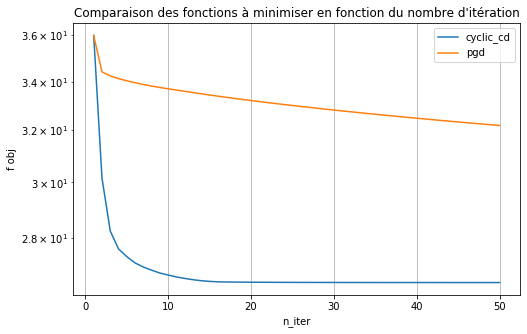

In [0]:
plt.figure(figsize=(8, 5))

y = obj_min_cd_linreg
z = obj_min_pgd

x = np.arange(1, len(y)+1)

plt.plot(x, y, label='cyclic_cd')
plt.plot(x, z, label='pgd')
plt.yscale('log')
plt.title("Comparaison des fonctions à minimiser en fonction du nombre d'itération")
plt.xlabel('n_iter')
plt.ylabel('f obj')
plt.grid()
plt.legend(loc='best')
plt.show()

## Conclusion
On remarque donc que dans ce cas la descente de gradient par coordonnées cyclique est bien plus rapide que l'algorithme PGD. En effet, on peut constater que l'algorithme de descente par coordonnées a seulement besoin de 15 itérations pour atteindre la valeur minimale de la fonction objectif tandis que la méthode proximale décroit très rapidement sur les 5 premières itérations puis devient bien plus lente et nécessite ainsi un nombre d'itérations beaucoup plus élevé pour atteindre la valeur optimale de la fonction objectif. <br/>

De plus, on a montré dans les notes de cours que la méthode de descente de gradient était plus lente que la méthode de descente par coordonnées. Les vitesses de convergences restant vraies pour les méthodes proximales, il est normal de voir la PGD plus lente que la CD. 